## KKBox EDA: Exploratory Data Analysis and Visualizations

In this notebook, we kick things off by exploring the following data sets provided by KKBox:
- Members
- Transactions
- Train


Our target variable which we will be predicting is the churn rate. So, our focus in this notebook is to gain understanding on the distributions of the provided features as well as their individual relationships with the churn rate.  

---

We begin by importing the necessary packages and reading in the csv files. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
members_df= pd.read_csv('data/members_v3.csv')

In [5]:
train_df = pd.read_csv('data/train_v2.csv')
transaction_v2_df = pd.read_csv('data/transactions_v2.csv')
transactions_v1_df = pd.read_csv('data/transactions.csv')
transactions_df =  transactions_v1_df.append(transaction_v2_df)

/var/folders/5k/bd6ybgj9359gmn4ggk9l01_r0000gn/T/ipykernel_49369/3232942371.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transactions_df =  transactions_v1_df.append(transaction_v2_df)


### 1. Exploratory Data Analysis

In [6]:
train_df.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   msno      970960 non-null  object
 1   is_churn  970960 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 14.8+ MB


In [8]:
train_df.describe()

,is_churn
count,970960.000000
mean,0.089942
std,0.286099
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [9]:
#Determine number of churn entries in train dataset
(train_df['is_churn']==1).sum()

87330

In [10]:
#Determine number of no churn entries in train dataset
(train_df['is_churn']==0).sum()

883630

The *train* file contains 970960 user(msno) entries, with the binary classification as 1 (churn) and 0 ( no churn). The majority of users are in no churn category (0) - about 92%, and about 8% of users have not churned.

### 1.1 Members Data Analysis

In [11]:
train_df = train_df.merge(members_df, on = 'msno', how = 'left')

In [12]:
train_df.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,20131223.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,20131227.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,NaN,7.0,20140109.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,female,7.0,20140125.0


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    970960 non-null  object 
 1   is_churn                970960 non-null  int64  
 2   city                    860967 non-null  float64
 3   bd                      860967 non-null  float64
 4   gender                  388905 non-null  object 
 5   registered_via          860967 non-null  float64
 6   registration_init_time  860967 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 59.3+ MB


The *members* data contains the kind of information typically found in a user profile (age, city, gender) together registration dates and methods.

In the merged dataset, the maximum non-null entries apart from is_churn is 860967 (city, bd, registered_via, registration_init_time).There are 109993 entries without any data (about 11%). The gender column contains most null entries (60%). We could fill the missing values with 0 (or unknown) but for now, we will not do this. First we will check the existing distribution between male and female, and then decide if it's worth keeping. 

To deal with the missing values in `city` and `registered_via`(registration method)we will create a function that fills null values with the mode. We choose the mode since we do not have consistent data for replacing with the mean or median and would run into the problem of large uncertainties. We will deal with age later, as we need to check for outliers first.

In [14]:
# This function uses mode to replace NaN values on train_df
def replacemode(i):
    train_df[i] = train_df[i].fillna(train_df[i].value_counts().index[0])
    return 

replacemode('city')
replacemode('registered_via')
#replacemode('bd')

We will convert the numeric columns from float to int:

In [15]:
# change the data type of city, bd and registered_via from float to int 
train_df['city'] = train_df['city'].astype(int)

In [16]:
train_df['registered_via'] = train_df['registered_via'].astype(int)

We will convert `registration_init_time` to datetime:

In [17]:
# convert registration_init_time to datetime
train_df['registration_init_time'] = pd.to_datetime(train_df['registration_init_time'], format = '%Y%m%d')

The cities in the dataset are the following:

In [18]:
train_df['city'].unique()

array([ 5, 13,  1, 22,  9, 12,  6, 14,  4, 15, 18,  3, 21,  8,  7, 17, 11,
       10, 20, 16, 19])

In [19]:
train_df.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28.0,male,3,2013-12-23
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,20.0,male,3,2013-12-23
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,18.0,male,3,2013-12-27
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1,0.0,NaN,7,2014-01-09
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,35.0,female,7,2014-01-25


---

### 1.2 Members Data Visualization

In this section, we will explore the frequency distributions of the features in our dataset, beginning with `city`.

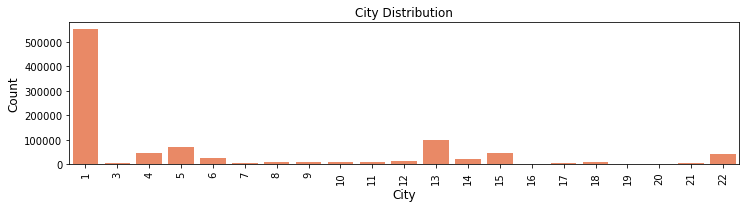

In [20]:
# City Distribution
plt.figure(figsize=(12,12))
plt.subplot(411)
city_order = train_df['city'].unique()
city_order=sorted(city_order, key=lambda x: float(x))
sns.countplot(x="city", data=train_df , order = city_order, color= 'coral')
plt.ylabel('Count', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("City Distribution", fontsize=12)
plt.show()

There are a total of 21 cities encoded. City "2" does not exist in the data set. Most users live in city "1". 

Now we will investigate the distribution of `registered_via`.

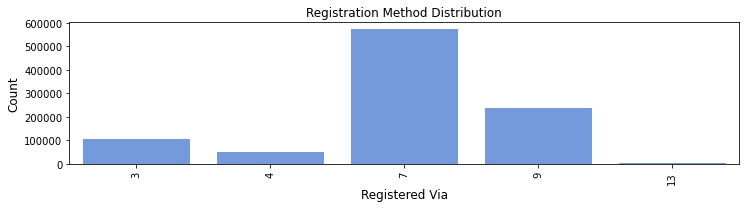

In [21]:
#Registered Via Count
plt.figure(figsize=(12,12))
plt.subplot(412)
sns.countplot(x="registered_via", data=train_df, color= 'cornflowerblue')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Registered Via', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Registration Method Distribution", fontsize=12)
plt.show()

There are 5 different *registration_via* methods: method "7" is clearly the most frequent one. Methods "3", "4", and "9" have similar frequencies that are still high. Method "13" is not popular.


Let's see the gender distribution:

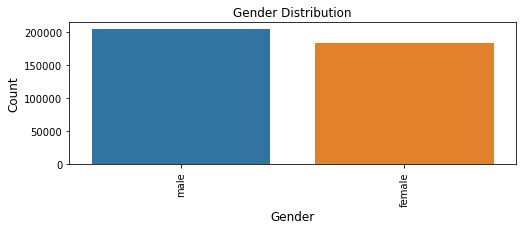

In [22]:
#Gender count
plt.figure(figsize=(8,12))
plt.subplot(413)
sns.countplot(x="gender", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Gender Distribution", fontsize=12)
plt.show()

While the majority of users (60%) did not provide information on their *gender*, those who did are pretty evenly split with just a sligthly higher number of "male" over "female" users. We will later check the relationship between gender and churn rate to see if they are correlated. 

---

Now that we have converted `registration_init_time` into datetime we can split it into year, month, and weekday and then plot out the distributions of each.

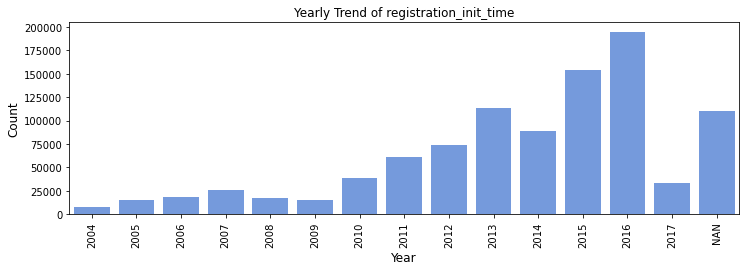

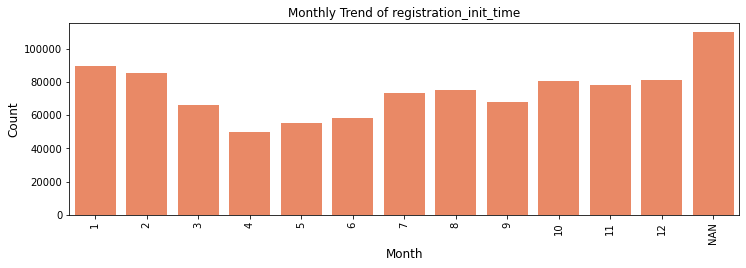

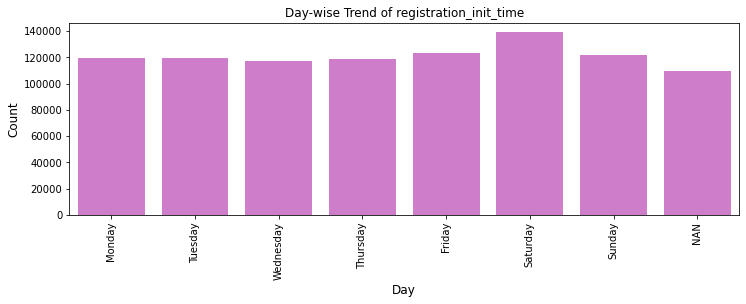

In [23]:
#registration_init_time yearly trend
train_df['registration_init_time_year'] = pd.DatetimeIndex(train_df['registration_init_time']).year
train_df['registration_init_time_year'] = train_df.registration_init_time_year.apply(lambda x: int(x) if pd.notnull(x) else "NAN")
year_count=train_df['registration_init_time_year'].value_counts()
#print(year_count)
plt.figure(figsize=(12,12))
plt.subplot(311)
year_order = train_df['registration_init_time_year'].unique()
year_order=sorted(year_order, key=lambda x: str(x))
year_order = sorted(year_order, key=lambda x: float(x))
sns.barplot(x=year_count.index,y=year_count.values,order=year_order, color='cornflowerblue')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Yearly Trend of registration_init_time", fontsize=12)
plt.show()

#registration_init_time monthly trend
train_df['registration_init_time_month'] = pd.DatetimeIndex(train_df['registration_init_time']).month
train_df['registration_init_time_month'] = train_df.registration_init_time_month.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
month_count=train_df['registration_init_time_month'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
month_order = train_df['registration_init_time_month'].unique()
month_order = sorted(month_order, key=lambda x: str(x))
month_order = sorted(month_order, key=lambda x: float(x))
sns.barplot(x= month_count.index, y= month_count.values,order=month_order, color='coral')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Monthly Trend of registration_init_time", fontsize=12)
plt.show()

#registration_init_time day wise trend
train_df['registration_init_time_weekday'] = train_df['registration_init_time'].dt.day_name()
train_df['registration_init_time_weekday'] = train_df.registration_init_time_weekday.apply(lambda x: str(x) if pd.notnull(x) else "NAN")
day_count=train_df['registration_init_time_weekday'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(313)
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','NAN']
sns.barplot(x=day_count.index, y=day_count.values, order=day_order, color='orchid')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Day-wise Trend of registration_init_time", fontsize=12)
plt.show()

After a slow start from 2004-2009, the popularity started rising slowly after 2010, with a dip in 2014, and increased strongly after 2015. The dataset has only the first quarter data for 2017. 

The monthly trend shows that Jan, Feb, and Oct-Dec have higher number of initial registrations than the rest of the months. Apr and May are the least popular months. 

We see that the weekend (Saturday and Sunday) have higher initial registration than the rest of the week. Amongs the weekdays only, Friday has higher registration numbers.

In order to use these time data, we have to deal with the null values. One method we can try is to replace the null values with the most common year, month, and day respectively. For example, when looking at the years, 2016 has the highest frequency so we can replace the null values with 2016.  

---

Now, we investigate the outliers and null values in the age feature, and then plot it's distribution.

In [24]:
# there are many outliers present for the age column
print(train_df['bd'].describe())

count    860967.000000
mean         13.583854
std          20.064040
min       -3152.000000
25%           0.000000
50%           0.000000
75%          27.000000
max        2016.000000
Name: bd, dtype: float64


The minimum and maximum age values do not make any sense at all. We will need to replace these outliers by keeping a more sensible age range between 1-100. Let's determine what the most frequent age is to use this metric as a way to replace missing values and outliers.

In [25]:
len( train_df[ train_df['bd']  > 104 ] )

388

In [26]:
tmp_1=train_df.bd.value_counts()
tmp_1.head()

0.0     473729
27.0     22786
26.0     21829
25.0     20651
24.0     20296
Name: bd, dtype: int64

Since age 0 is the most common, it is not going to be useful for replacing. We can now see that the age ranges of users are between 20 (if we go with the standard deviation) and 27 (mode besides 0) with a mean of 13. The mean is not a good choice because it is skewed by the outliers. The safest age to choose would be 20 because it is in the middle. 

In [27]:
train_df['bd'] = train_df.bd.apply(lambda x: int(x) if pd.notnull(x) else "NAN")

In [28]:
# replace outliers with std (alternatively could be replaced with 75%)
train_df['bd'] = train_df.bd.apply(lambda x: 20 if float(x)<=1 else x )
train_df['bd'] = train_df.bd.apply(lambda x: 20 if float(x)>=100 else x )

Now that we have replaced the missing values and outliers, we can look at the distribution again and get more realistic mean and median values. 

Mean of Birth Date = 24.44805433890033
Median of Birth Date = 20.0


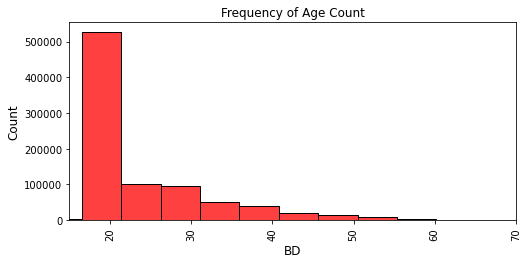

In [29]:
#Birth Date count in training Data Set without outliers and NAN
tmp_bd = train_df[(train_df.bd != "NAN")] 
print("Mean of Birth Date = " +str(np.mean(tmp_bd['bd'])))
print("Median of Birth Date = " +str(np.median(tmp_bd['bd'])))
plt.figure(figsize=(8,8))
plt.subplot(211)
bd_order = tmp_bd['bd'].unique()
bd_order = sorted(bd_order, key=lambda x: float(x))
#sns.countplot(x="bd", data=tmp_bd , order = bd_order)
sns.histplot(tmp_bd['bd'],bins=20,color='r')
plt.ylabel('Count', fontsize=12)
plt.xlabel('BD', fontsize=12)
plt.xlim(15,70)
plt.xticks(rotation='vertical')
plt.title("Frequency of Age Count", fontsize=12)
plt.show()

The most common users are young adults between 20-30 years old. After which the age distribution declines towards 60.

### 1.3 Exploring Members Dataset and Churn

Now we will look into the isolated relationships between churn and a given feature from the members data to investigate member behaviour regarding churn. First we investigate the ages and whether or not the users of a given age are more likely to churn. 

Text(0.5, 1.0, 'Churn Distribution by Age')

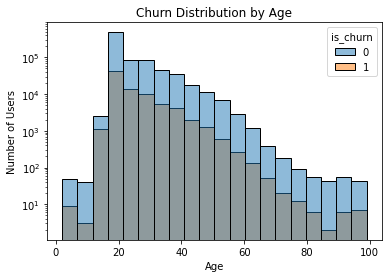

In [30]:
sns.histplot(data= tmp_bd, x= 'bd', hue = 'is_churn', bins=20)
plt.yscale('log')
plt.ylabel('Number of Users')
plt.xlabel('Age')
plt.title('Churn Distribution by Age')

We knew from our previous plot that 20-30 year olds were the most frequent users. We looked into the churn distribution by age to see if there are any noticeable patterns or differences between churning and not churning based on age. We can see that the distributions follow the same right-skewed distribution where 20-30 year olds are the most likely to both churn and not churn. This is because they are the most frequent users. But at least we gained information that there's no unexpected sudden change in pattern. 

Now let's determine the churn distribution by city. 

city
1     0.066041
3     0.153250
4     0.148154
5     0.152070
6     0.147877
7     0.125637
8     0.155451
9     0.144127
10    0.152887
11    0.136285
12    0.161768
13    0.140281
14    0.134331
15    0.147096
16    0.123810
17    0.116412
18    0.132723
19    0.138211
20    0.119008
21    0.172530
22    0.143951
Name: Ratio, dtype: float64

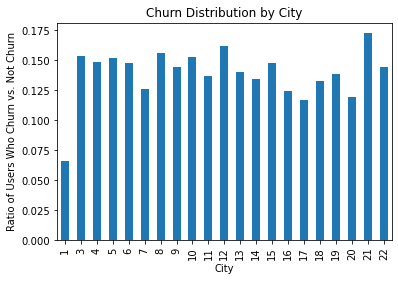

In [32]:
#city
city_crosstab=pd.crosstab(train_df['city'],train_df['is_churn'])
city_crosstab["Ratio"] =  city_crosstab[1] / city_crosstab[0]
city_crosstab["Ratio"].plot(kind='bar', stacked=True)

plt.ylabel('Ratio of Users Who Churn vs. Not Churn')
plt.xlabel('City')
plt.title('Churn Distribution by City')

city_crosstab["Ratio"]

We can see that city 1 has the highest number of users who do not churn, which we know from our previous city frequency distribution that this city has the most members. All of the cities have an imblanced split of more users who do not churn vs. users who churn. This is a good thing for the business! The churn rate across all cities except city 1 vary between 6% and 17%. City 1 has a churn rate of 6%. What is interesting is that the mean across all cities when we include city 1 is 9%. City 1 has the greatest influence as this is where most of the members live.

In [42]:
stats.chi2_contingency(city_crosstab)[1]

0.0

With a p-value of 0, we can reject the null hypothesis that `city` and `is_churn` are independent. It appears that there is a statistically significant difference between `city` and `is_churn` since the p-value is less than 0.05. 

Next we can visualize the churn distribution by registration method.

is_churn,0,1,Ratio
registered_via,,,
3,88121,18338,0.208100
4,40559,12185,0.300427
7,546098,26579,0.048671
9,205796,29893,0.145255
13,3056,335,0.109620


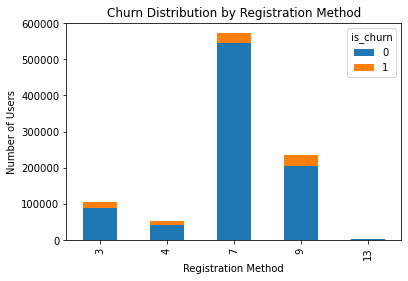

In [34]:
#Registered Via
registered_via_crosstab=pd.crosstab(train_df['registered_via'],train_df['is_churn'])
registered_via_crosstab.plot(kind='bar', stacked=True)

plt.ylabel('Number of Users')
plt.xlabel('Registration Method')
plt.title('Churn Distribution by Registration Method')
registered_via_crosstab["Ratio"] =  registered_via_crosstab[1] / registered_via_crosstab[0]
registered_via_crosstab

It appears that registration method gives us some insight into user churn behaviour. When comparing the ratios of churn rate across the registration methods used, we find that for the second least used method, 4, the churn rate is highest at 30% while the most used method 7 has the lowest churn rate of 4%. Method 9 is the second most used method and has a churn rate of 14.5%. This feature is a good candidate for our churn model prediction. 

In [41]:
stats.chi2_contingency(registered_via_crosstab)

(38822.75138632618,
 0.0,
 8,
 array([[9.68839822e+04, 9.57513684e+03, 8.90382941e-02],
        [4.80003370e+04, 4.74391932e+03, 4.41132582e-02],
        [5.21168943e+05, 5.15076263e+04, 4.78964558e-01],
        [2.14490633e+05, 2.11983149e+04, 1.97121130e-01],
        [3.08610415e+03, 3.05002632e+02, 2.83619070e-03]]))

With a p-value of 0, we can reject the null hypothesis that `registered_via` and `is_churn` are independent. It appears that there is a statistically significant difference between `registered_via` and `is_churn` since the p-value is less than 0.05. 

We now turn our attention to `gender` to see if there are any differences in the churn rate. 

is_churn,0,1,Ratio
gender,,,
female,160404,23940,0.149248
male,178165,26396,0.148155


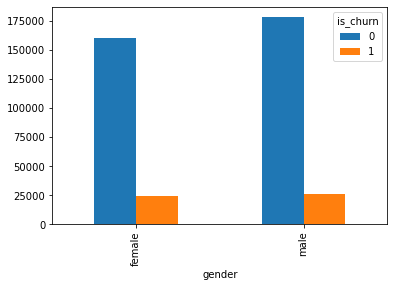

In [37]:
#Gender
gender_crosstab=pd.crosstab(train_df['gender'],train_df['is_churn'])
gender_crosstab.plot(kind='bar')
gender_crosstab["Ratio"] =  gender_crosstab[1] / gender_crosstab[0]
gender_crosstab

Since the churn rate is the same for both users, gender does not appear to tell us much about churn. We can probably drop this feature since it also contains many null values. 

In [39]:
stats.chi2_contingency(gender_crosstab)[1]

0.7438813248251515

With a p-value of 0.7, we cannot reject the null hypothesis because `gender` and `is_churn` are dependent. It appears that there is no statistical significant difference between `gender` and `is_churn` since the p-value is greater than 0.05. This is as we expected and so now we have statistical grounds for our decision in dropping gender. 

Now we can look at the churn rate across the dates, beginning with the yearly initial registration. 

is_churn,0,1,Ratio
registration_init_time_year,,,
2004,7598,732,0.096341
2005,14553,1063,0.073043
2006,16579,1469,0.088606
2007,23792,2366,0.099445
2008,15909,1776,0.111635
2009,13987,1744,0.124687
2010,34143,4497,0.131711
2011,55366,5332,0.096305
2012,67327,7168,0.106465


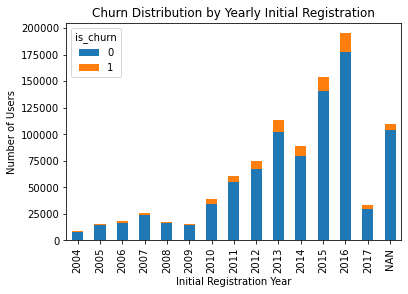

In [43]:
# initial registration year
reg_crosstab_year=pd.crosstab(train_df['registration_init_time_year'],train_df['is_churn'])
reg_crosstab_year.plot(kind='bar', stacked= True)
plt.xlabel('Initial Registration Year')
plt.ylabel('Number of Users')
plt.title('Churn Distribution by Yearly Initial Registration')
reg_crosstab_year["Ratio"] =  reg_crosstab_year[1] / reg_crosstab_year[0]
reg_crosstab_year

The churn ratio for yearly initial registration range between 7% and 13%. Users were churning less in earlier years, but after the app gained more popularity we also see the churn rate trend going up for users who registered in 2010 and 2017 with the highest churn rate at 13%. This is also a good candidate for our churn model prediction. 

In [45]:
stats.chi2_contingency(reg_crosstab_year)

(3140.245188741987,
 0.0,
 28,
 array([[7.58085954e+03, 7.49223616e+02, 1.31886356e-02],
        [1.42115111e+04, 1.40453726e+03, 2.47241674e-02],
        [1.64247830e+04, 1.62327705e+03, 2.85746592e-02],
        [2.38053522e+04, 2.35270578e+03, 4.14148441e-02],
        [1.60944534e+04, 1.59063026e+03, 2.79999754e-02],
        [1.43162146e+04, 1.41488521e+03, 2.49063231e-02],
        [3.51647087e+04, 3.47536187e+03, 6.11770375e-02],
        [5.52387059e+04, 5.45929426e+03, 9.61003379e-02],
        [6.77947667e+04, 6.70022179e+03, 1.17944472e-01],
        [1.03240569e+05, 1.02033644e+04, 1.79610536e-01],
        [8.12972880e+04, 8.03468891e+03, 1.41435190e-01],
        [1.40490990e+05, 1.38848592e+04, 2.44416146e-01],
        [1.77628585e+05, 1.75552033e+04, 3.09025469e-01],
        [3.02413010e+04, 2.98877677e+03, 5.26116461e-02],
        [1.00099912e+05, 9.89297027e+03, 1.74146646e-01]]))

With a p-value of 0, we can reject the null hypothesis that `registered_via` and `is_churn` are independent. It appears that there is a statistically significant difference between `registered_via` and `is_churn` since the p-value is less than 0.05. 

Now we look at the months to see if users churn in particular months. 

is_churn,0,1,Ratio
registration_init_time_month,,,
1,80691,8949,0.110905
2,76593,9035,0.117961
3,58027,7911,0.136333
4,45004,4728,0.105057
5,50419,5025,0.099665
6,53218,5364,0.100793
7,67361,5843,0.086742
8,68437,6631,0.096892
9,61383,6602,0.107554


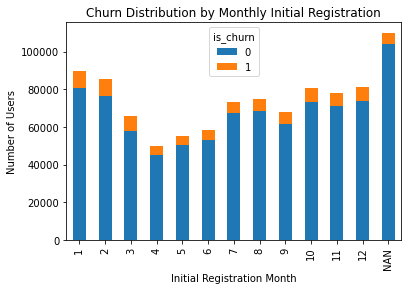

In [47]:
# initial registration month
reg_crosstab_month=pd.crosstab(train_df['registration_init_time_month'],train_df['is_churn'])
reg_crosstab_month.plot(kind='bar', stacked=True)
plt.xlabel('Initial Registration Month')
plt.ylabel('Number of Users')
plt.title('Churn Distribution by Monthly Initial Registration')
reg_crosstab_month["Ratio"] =  reg_crosstab_month[1] / reg_crosstab_month[0]
reg_crosstab_month

The churn ratios for monthly initial registration range between 8% and 13%. Users who registered in March have the highest churn rate at 13%. We know from earlier that the monthly distribution showed us that the most frequent months of registration were the fall and winter months from October-February. This can also be a good candidate for churn prediction. 

In [48]:
stats.chi2_contingency(reg_crosstab_month)

(3040.2574519323566,
 0.0,
 24,
 array([[8.15775976e+04, 8.06239218e+03, 1.21100058e-01],
        [7.79264559e+04, 7.70154635e+03, 1.15680023e-01],
        [6.00074531e+04, 5.93059412e+03, 8.90796771e-02],
        [4.52590432e+04, 4.47299463e+03, 6.71860036e-02],
        [5.04572831e+04, 4.98674166e+03, 7.49026705e-02],
        [5.33130425e+04, 5.26897910e+03, 7.91419794e-02],
        [6.66198811e+04, 6.58410672e+03, 9.88956737e-02],
        [6.83162363e+04, 6.75175913e+03, 1.01413874e-01],
        [6.18703133e+04, 6.11470238e+03, 9.18450500e-02],
        [7.32851488e+04, 7.24284151e+03, 1.08790109e-01],
        [7.09736005e+04, 7.01438898e+03, 1.05358669e-01],
        [7.39240090e+04, 7.30598068e+03, 1.09738483e-01],
        [1.00099935e+05, 9.89297257e+03, 1.48596040e-01]]))

Now let's look in the weekdays.

is_churn,0,1,Ratio
registration_init_time_weekday,,,
Friday,111931,11707,0.104591
Monday,108717,11176,0.102799
NAN,104111,5882,0.056497
Saturday,126299,12969,0.102685
Sunday,109904,12283,0.111761
Thursday,107685,11196,0.103970
Tuesday,108724,11060,0.101725
Wednesday,106259,11057,0.104057


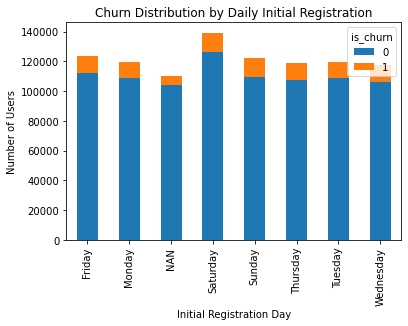

In [49]:
reg_crosstab_weekday=pd.crosstab(train_df['registration_init_time_weekday'],train_df['is_churn'])
reg_crosstab_weekday.plot(kind='bar', stacked=True)
plt.xlabel('Initial Registration Day')
plt.ylabel('Number of Users')
plt.title('Churn Distribution by Daily Initial Registration')
reg_crosstab_weekday["Ratio"] =  reg_crosstab_weekday[1] / reg_crosstab_weekday[0]
reg_crosstab_weekday

The churn ratios are very similar for initial registration throughout the weekdays ranging from 10% to 11% across all days of the week. Since there are no differences, this feature does not seem to be a good predictor of churn. 

In [50]:
stats.chi2_contingency(reg_crosstab_weekday)

(2082.136420366195,
 0.0,
 14,
 array([[1.12517766e+05, 1.11202386e+04, 1.00351609e-01],
        [1.09109599e+05, 1.07834063e+04, 9.73119558e-02],
        [1.00099989e+05, 9.89297791e+03, 8.92765239e-02],
        [1.26741960e+05, 1.25260294e+04, 1.13037791e-01],
        [1.11197279e+05, 1.09897337e+04, 9.91739020e-02],
        [1.08188622e+05, 1.06923853e+04, 9.64905609e-02],
        [1.09010402e+05, 1.07736025e+04, 9.72234845e-02],
        [1.06764383e+05, 1.05516263e+04, 9.52203194e-02]]))

### 1.4 Transactions Dataset Analysis 

In the transactions dataset we find payment and membership related information. In this section, we look for unique msno (member id) transaction behaviour as well as any missing values. 

In [51]:
transactions_df.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


In [52]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22978755 entries, 0 to 1431008
Data columns (total 9 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   msno                    object
 1   payment_method_id       int64 
 2   payment_plan_days       int64 
 3   plan_list_price         int64 
 4   actual_amount_paid      int64 
 5   is_auto_renew           int64 
 6   transaction_date        int64 
 7   membership_expire_date  int64 
 8   is_cancel               int64 
dtypes: int64(8), object(1)
memory usage: 1.7+ GB


In [53]:
transactions_df.shape

(22978755, 9)

There are 22,978,755 entries in trasactions data set, compared to 970,960 entries in training set (about 4%)

In [54]:
tmp1=transactions_df[transactions_df.msno=="LNScSgIQZsX+hC3eVrwGFcdan0nftusOwk0jMAu7q9I="]
tmp1=tmp1.sort_values('transaction_date')
tmp1

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
21168492,LNScSgIQZsX+hC3eVrwGFcdan0nftusOwk0jMAu7q9I=,36,30,150,150,0,20160120,20160219,0
7190561,LNScSgIQZsX+hC3eVrwGFcdan0nftusOwk0jMAu7q9I=,36,30,150,150,0,20160220,20160321,0
2677004,LNScSgIQZsX+hC3eVrwGFcdan0nftusOwk0jMAu7q9I=,36,30,150,150,0,20160322,20160421,0
11056693,LNScSgIQZsX+hC3eVrwGFcdan0nftusOwk0jMAu7q9I=,36,30,180,180,0,20160422,20160522,0
10331877,LNScSgIQZsX+hC3eVrwGFcdan0nftusOwk0jMAu7q9I=,36,30,180,180,0,20160523,20160622,0
11867363,LNScSgIQZsX+hC3eVrwGFcdan0nftusOwk0jMAu7q9I=,36,30,180,180,0,20160623,20160723,0
423621,LNScSgIQZsX+hC3eVrwGFcdan0nftusOwk0jMAu7q9I=,36,30,180,180,0,20160724,20160823,0
9228113,LNScSgIQZsX+hC3eVrwGFcdan0nftusOwk0jMAu7q9I=,36,30,180,180,0,20160831,20160930,0


Transactions data set has more than one entry for many users. A member could use a different payment method, sign up for a different plan, or renew on multiple transaction dates. The above sample shows the data of one such user with 8 entries in the data set. This member was in the 150 plan price for three months, and then changed to an 180 plan price for the next 5 months.

In [55]:
transactions_df['msno'].nunique()

2426143

Out of all transactions, only 10% represent unique members. This tells us that majority of users have multiple transactions recorded. We will create a new feature that counts the number of transactions per user to see the correlation with churn in the feature engineering notebook. 

In [56]:
transactions_df.isna().sum()

msno                      0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
dtype: int64

There are no missing values. We can proceed to the next section to visualize this dataset.

### 1.5 Transactions Data Visualization

In this section, we visualize the frequency distributions of the features in the `transactions` dataset beginning with `payment_method_id`. 

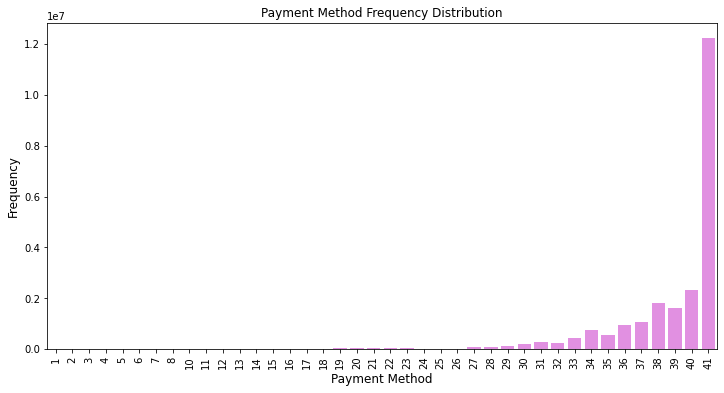

In [57]:
# payment_method_id count in transactions 
plt.figure(figsize=(12,6))
#plt.subplot(311)
sns.countplot(x="payment_method_id", data=transactions_df, color= 'violet')
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_method_id', fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Payment Method')
plt.ylabel('Frequency')
plt.title("Payment Method Frequency Distribution", fontsize=12)
plt.show()

There are 40 payment methods where payment method 9 is missing. Payment method 41 is the most frequently used. Other payment methods beginning from around 34 also contribute a notable fraction compared to those with smaller numbers, but the spike at 41 makes these other methods much less significant.

Now we investigate the distribution of the payment plan days

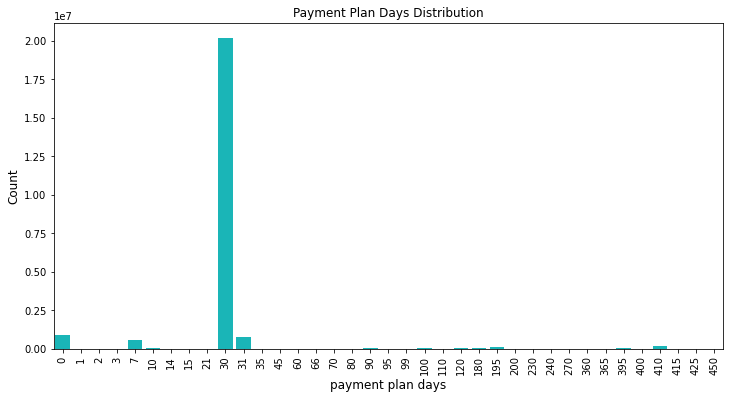

In [58]:
# payment_plan_days count in transactions 
plt.figure(figsize=(12,6))
sns.countplot(x="payment_plan_days", data=transactions_df, color= 'darkturquoise')
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment plan days', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Payment Plan Days Distribution", fontsize=12)
plt.show()

As expected, the monthly payment plan is the most frequent. It appears there are also some users who opt for a weekly trial plan, as well as a 0 day trial pass. An insignificant amount of users have 90, 100, 120, 180, 195, 395, and 410 day plans. 

Next we view the distribution in the plan prices. 

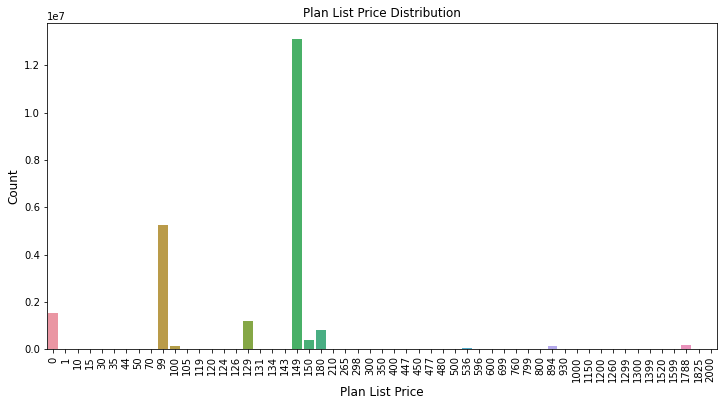

In [59]:
# plan_list_price count in transactions 
plt.figure(figsize=(12,6))
sns.countplot(x="plan_list_price", data=transactions_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Plan List Price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Plan List Price Distribution", fontsize=12)
plt.show()

There are 53 different plan list prices, out of which 149 is the most frequent, followed by 99.

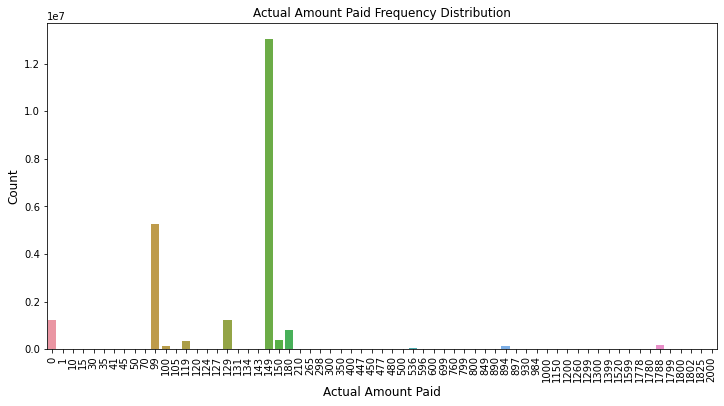

In [60]:
# actual_amount_paid  count in transactions 
plt.figure(figsize=(12,6))
sns.countplot(x="actual_amount_paid", data=transactions_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Actual Amount Paid', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Actual Amount Paid Frequency Distribution", fontsize=12)
plt.show()

The plan list price and the actual amount that users pay for the plans have very similar distributions. A small noticeable difference occurs at a plan of $ 119 where users acually paid this amount. Having these as separate features will distort our prediction for churn because they are telling us the same information. Let's check for correlation to confirm this:

In [61]:
#Correlation between plan_list_price and actual_amount_paid
transactions_df['plan_list_price'].corr(transactions_df['actual_amount_paid'],method='pearson')  

0.9635363002049566

As expected, there is a high correlation of 96% between the plan list price and the actual amount paid. 

Now we can check the renewal and cancellation transactions to get a sense of this behaviour. We begin with `is_auto_renew`.

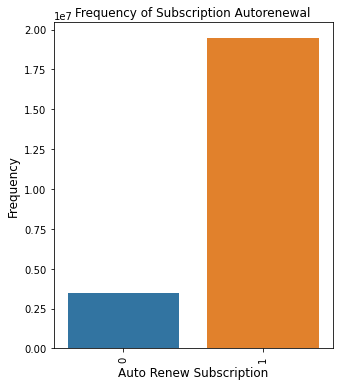

In [62]:
# is_auto_renew distribution 
plt.figure(figsize=(5,6))
sns.countplot(x="is_auto_renew", data=transactions_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Auto Renew Subscription', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Subscription Autorenewal", fontsize=12)
plt.show()

We can see that majority of users automatically renew their subscriptions to KKBox.

Next we check cancellations. It is important to note that cancellation does not imply churn. Members may cancel one subscription and purchase another. But we do suspect that cancellations can result in churn and will look into this in more detail later. 

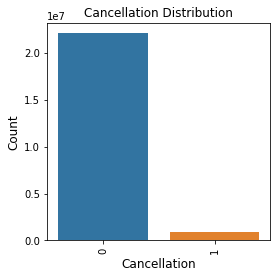

In [63]:
# is_cancel count in transactions
plt.figure(figsize=(4,4))
sns.countplot(x="is_cancel", data=transactions_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Cancellation', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Cancellation Distribution", fontsize=12)
plt.show()

Many more users do not cancel their subscriptions vs. users who do cancel. 

Transactions data set has more than one entry for many users. A member could use a different payment method, sign up for a different plan, or renew on multiple transaction dates. The above sample shows the data of one such user with 8 entries in the data set. This member was in the 150 plan price for three months, and then changed to an 180 plan price for the next 5 months.

### 1.6 Transaction Features and Churn Visualization

In this section, we begin by merging the transaction datset into our main train dataframe. 

In [64]:
# merge transaction dataframe into train
train_df = train_df.merge(transactions_df, on = 'msno', how = 'left')

In [65]:
train_df.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,registration_init_time_year,registration_init_time_month,registration_init_time_weekday,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,2013-12-23,2013,12,Monday,38,30,149,149,0,20170228,20170330,0
1,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,2013-12-23,2013,12,Monday,31,0,0,149,1,20150331,20150430,0
2,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,2013-12-23,2013,12,Monday,31,0,0,149,1,20150630,20150731,0
3,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,2013-12-23,2013,12,Monday,31,30,149,149,1,20150902,20150901,1
4,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,2013-12-23,2013,12,Monday,31,0,0,149,1,20150831,20150930,0


In [66]:
train_df.shape

(16255622, 18)

In [67]:
train_df.isna().sum()

msno                                    0
is_churn                                0
city                                    0
bd                                      0
gender                            9121083
registered_via                          0
registration_init_time            1596663
registration_init_time_year             0
registration_init_time_month            0
registration_init_time_weekday          0
payment_method_id                       0
payment_plan_days                       0
plan_list_price                         0
actual_amount_paid                      0
is_auto_renew                           0
transaction_date                        0
membership_expire_date                  0
is_cancel                               0
dtype: int64

There are no new missing values. We will be dropping `gender` as previously outlined, and `registration_init_time` since we already split it into year, month, and weekday.  

**Churn Visualizations**

First we visualize the relation between the payment method and churn. 

is_churn,0,1,Ratio
payment_method_id,,,
2,6,4,0.666667
3,24,35,1.458333
4,1,1,1.000000
5,58,20,0.344828
6,47,45,0.957447
8,138,58,0.420290
10,1042,108,0.103647
11,1863,73,0.039184
12,485,600,1.237113


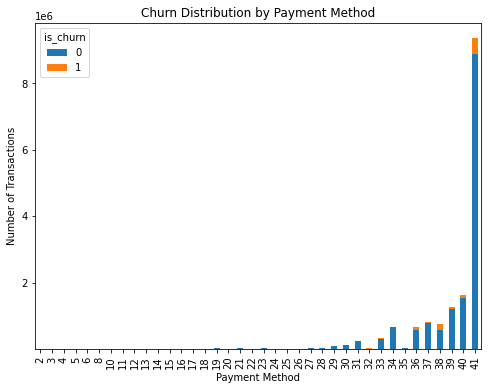

In [69]:
# Payment method
payment_method_crosstab=pd.crosstab(train_df['payment_method_id'],train_df['is_churn'])
payment_method_crosstab.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.xlabel('Payment Method')
plt.ylabel('Number of Transactions')
plt.title('Churn Distribution by Payment Method')
payment_method_crosstab["Ratio"] =  payment_method_crosstab[1] / payment_method_crosstab[0]

payment_method_crosstab

The churn rate ratios vary between 1.6% and 39% across the payment methods used from 29 onwards. The most used payment method, 41, has a churn rate of 5%. This seems low at first, however, 5% of 9.35 million total transactions having payment method 41 is 467,452 transactions that resulted in churn. 

In [71]:
stats.chi2_contingency(payment_method_crosstab)[1]

0.0

Next, we visualize the churn distribution by the payment plan days. 

is_churn,0,1,Ratio
payment_plan_days,,,
0,551767,29367,0.053224
1,2102,866,0.411989
2,3,1,0.333333
3,5,9,1.800000
7,29632,15650,0.528145
10,1984,2548,1.284274
14,362,229,0.632597
15,2,1,0.500000
21,43,51,1.186047


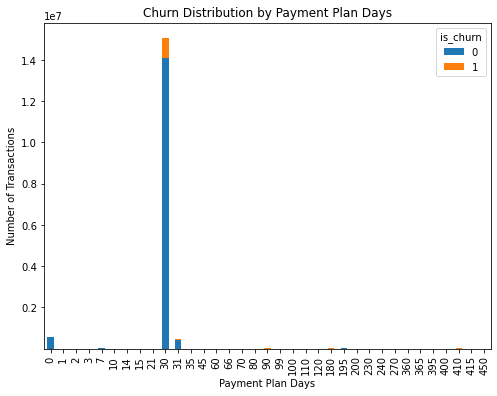

In [72]:
# Payment plan days churn
payment_plan_crosstab=pd.crosstab(train_df['payment_plan_days'],train_df['is_churn'])
payment_plan_crosstab.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.xlabel('Payment Plan Days')
plt.ylabel('Number of Transactions')
plt.title('Churn Distribution by Payment Plan Days')
payment_plan_crosstab["Ratio"] =  payment_plan_crosstab[1] / payment_plan_crosstab[0]
payment_plan_crosstab

The lowest churn numbers are associated with the 30-day, 31-day, and (surprisingly) the 0-day memberships. The churn percentage  for 7-day plans is above 50%, and for 14-day plans is 63%. The most popular plan is the 30-day plan, with a churn rate of 6.7%.

In [74]:
stats.chi2_contingency(payment_plan_crosstab)[1]

0.0

Visualizing the relationship between the price of the plan and the frequency of churn, we obtain the following results:

is_churn,0,1,Ratio
plan_list_price,,,
0,585417,50718,0.086636
1,4,19,4.750000
10,3,1,0.333333
15,5,1,0.200000
35,1034,943,0.911992
50,120,72,0.600000
70,30,26,0.866667
99,4493181,157591,0.035073
100,100790,3417,0.033902


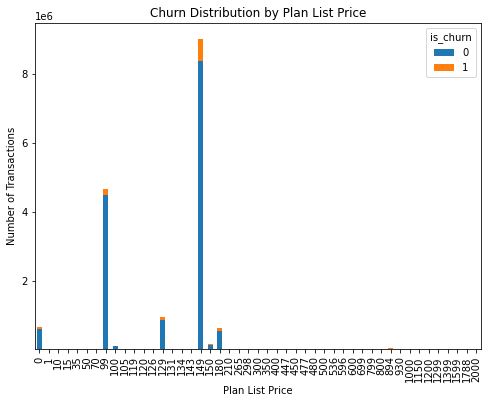

In [75]:
# plan list price
plan_price_crosstab=pd.crosstab(train_df['plan_list_price'],train_df['is_churn'])
plan_price_crosstab.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.xlabel('Plan List Price')
plt.ylabel('Number of Transactions')
plt.title('Churn Distribution by Plan List Price')
plan_price_crosstab["Ratio"] =  plan_price_crosstab[1] / plan_price_crosstab[0]
plan_price_crosstab

The most frequently listed price paid by members for their plan is 149. Members in this payment category have a churn rate of 7%. The second most frequently listed price paid is 99. Members in this payment category have a churn rate of 3.5%. Members paying 129 for their plan have a churn rate of 9%, and the ones paying 180 have a churn rate of 13%.This feature, as well as variations of it, will be an important feature for our churn prediction model as we can classify the types of members that churn based on their plan type by price (and in combination with the previous feature for the plan duration)

We now look at the transaction behaviour regarding autorenewal and cancellations, and how they relate to churn.

is_churn,0,1,Ratio
is_auto_renew,,,
0,964662,317794,0.329436
1,14199457,773709,0.054489


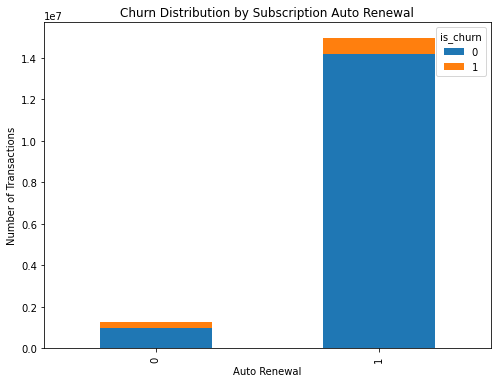

In [77]:
# Auto renewal churn
auto_renew_crosstab=pd.crosstab(train_df['is_auto_renew'],train_df['is_churn'])
auto_renew_crosstab.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.xlabel('Auto Renewal')
plt.ylabel('Number of Transactions')
plt.title('Churn Distribution by Subscription Auto Renewal')
auto_renew_crosstab["Ratio"] =  auto_renew_crosstab[1] / auto_renew_crosstab[0]
auto_renew_crosstab

Members on subscription auto renewal have a significantly lower churn rate of 5% over members who are not enrolled in auto renewal with a churn rate of 33%.

In [78]:
stats.chi2_contingency(auto_renew_crosstab)

(725435.5859477944,
 0.0,
 2,
 array([[1.19634425e+06, 8.61120478e+04, 3.02889698e-02],
        [1.39677747e+07, 1.00539095e+06, 3.53635258e-01]]))

is_churn,0,1,Ratio
is_cancel,,,
0,14930693,1043633,0.069898
1,233426,47870,0.205076


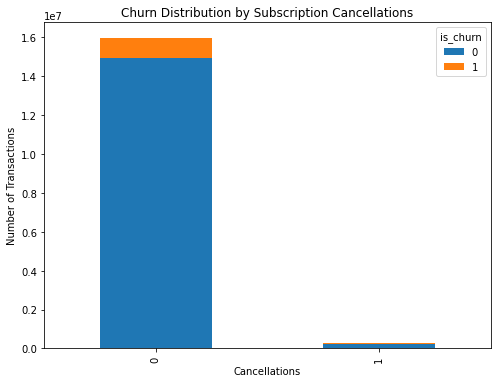

In [80]:
# Cancel
is_cancel_crosstab=pd.crosstab(train_df['is_cancel'],train_df['is_churn'])
is_cancel_crosstab.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.xlabel('Cancellations')
plt.ylabel('Number of Transactions')
plt.title('Churn Distribution by Subscription Cancellations')
is_cancel_crosstab["Ratio"] =  is_cancel_crosstab[1] / is_cancel_crosstab[0]
is_cancel_crosstab

Members who did not cancel their subscription have a churn ratio of about 7%, while members who did cancel have a higher churn rate of 20%. This is not surprising as it is more likely that members who cancel will probably churn, however they could also subscribe to another plan.

In [81]:
stats.chi2_contingency(is_cancel_crosstab)

(48519.59646407465,
 0.0,
 2,
 array([[1.49017108e+07, 1.07261503e+06, 2.70215891e-01],
        [2.62408234e+05, 1.88879667e+04, 4.75830432e-03]]))